<a href="https://colab.research.google.com/github/Afrisca/Afrisca.github.io/blob/main/TubesBioinformatika_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalasi dan Impor Library

In [ ]:
# ==============================================================================
# INSTALASI DAN IMPOR LIBRARY
# ==============================================================================

!pip install biopython scikit-learn tensorflow

import pandas as pd
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

Persiapan Data (Ngumpulin Data, Gabungin, Labelin)

In [ ]:
# ==============================================================================
# PERSIAPAN DATA (NGUMPULIN, GABUNGIN, LABELIN)
# ==============================================================================

# 1.1 Ngumpulin Data (Akses Google Drive)
drive.mount('/content/drive')

# Definisikan direktori dan daftar file
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/TubesBioinformatika/'
file_list = [
    ('hepatitisA.fasta', 'HepatitisA'),
    ('hepatitisB.fasta', 'HepatitisB')
]

all_sequences = []

# 1.2 Gabungin & 1.3 Labelin (Parsing FASTA)
for file_name, label in file_list:
    file_path = BASE_DIR + file_name
    print(f"Memproses file: {file_name} dengan label: {label}...")

    try:
        for record in SeqIO.parse(file_path, "fasta"):
            all_sequences.append({
                'id': record.id,
                'label': label,
                'sequence': str(record.seq).upper()
            })
    except FileNotFoundError:
        print(f"⚠️ ERROR: File {file_name} tidak ditemukan. Pastikan jalur sudah benar.")

# Buat DataFrame
data_df = pd.DataFrame(all_sequences)

print(f"\n✅ Total sekuens yang berhasil dimuat: {len(data_df)}")
print("Distribusi Label Sekuens:\n", data_df['label'].value_counts())
print("\nLima data teratas:\n", data_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memproses file: hepatitisA.fasta dengan label: HepatitisA...
Memproses file: hepatitisB.fasta dengan label: HepatitisB...

✅ Total sekuens yang berhasil dimuat: 100
Distribusi Label Sekuens:
 label
HepatitisA    50
HepatitisB    50
Name: count, dtype: int64

Lima data teratas:
          id       label                                           sequence
0  M14707.1  HepatitisA  TTCAAGAGGGGTCTCCGGGAATTTCCGGAGTCCCTCTTGGAAGTCC...
1  M16632.1  HepatitisA  TTCAAGAGGGGTCTCCGGGAATTTCCGGAGTCCCTCTTGGAAGTCC...
2  M59809.1  HepatitisA  GTCCCTCTTGGAAGTCCATGGTGAGGGGACTTGATACCTCACCGCC...
3  M59810.1  HepatitisA  GTCCCTCTTGGAAGTCCATGGTGAGGGGACTTGATACCTCACCGCC...
4  M59808.1  HepatitisA  GTCCCTCTTGGAAGTCCATGGTGAGGGGACTTGATACCTCACCGCC...


Pra-pemrosesan & Split Data (K-mer, Tokenisasi, Padding, One Hot)

In [ ]:
# ==============================================================================
# PRAPROSES DATA
# ==============================================================================

# --- A. PRAPROSES UNTUK ML KLASIK (K-MER COUNTING) ---
K = 4
def get_kmer_list(sequence, k=K):
    return [sequence[i:i + k] for i in range(len(sequence) - k + 1)]

# 2.1 K-mer Counting
data_df['words'] = data_df.apply(lambda x: get_kmer_list(x['sequence']), axis=1)
all_words = [' '.join(words) for words in data_df['words']]

# Buat Matriks Fitur K-mer
vectorizer = CountVectorizer(ngram_range=(1,1))
kmer_features = vectorizer.fit_transform(all_words)

X_kmer = kmer_features
y_label = data_df['label']

print(f"\n✅ Matriks K-mer siap. Shape: {X_kmer.shape}")

# --- B. PRAPROSES UNTUK DEEP LEARNING (TOKENISASI, PADDING, ONE-HOT) ---

# 2.2 Tokenisasi (Sekuens ke Angka)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(data_df['sequence'])
sequences_tokenized = tokenizer.texts_to_sequences(data_df['sequence'])

# 2.3 Padding (Samakan Panjang Sekuens)
MAX_LENGTH = max(len(s) for s in sequences_tokenized)
X_dl = tf.keras.preprocessing.sequence.pad_sequences(sequences_tokenized, maxlen=MAX_LENGTH, padding='post')

# 2.4 One Hot (Label)
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(data_df['label'])
y_dl = to_categorical(encoded_labels)
NUM_CLASSES = y_dl.shape[1]

print(f"✅ Praproses Deep Learning selesai. MAX_LENGTH: {MAX_LENGTH}, Shape DL: {X_dl.shape}")



✅ Matriks K-mer siap. Shape: (100, 372)
✅ Praproses Deep Learning selesai. MAX_LENGTH: 7478, Shape DL: (100, 7478)


SPLIT DATA (80:20)

In [ ]:
# --- C. SPLIT DATA (80:20) ---

# Split untuk ML Klasik (K-mer)
X_train, X_test, y_train, y_test = train_test_split(
    X_kmer, y_label, test_size=0.2, random_state=42, stratify=y_label
)

# Split untuk Deep Learning (Tokenized)
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=0.2, random_state=42, stratify=encoded_labels
)

print("\n✅ Data berhasil di-Split (80:20).")
print(f"Data Latih K-mer: {X_train.shape}")


✅ Data berhasil di-Split (80:20).
Data Latih K-mer: (80, 372)


K-MEANS CLUSTERING & VISUALISASI PCA


✅ K-Means Clustering selesai (K=2).
Perbandingan Label Asli vs. Hasil Cluster:
cluster      0   1
label             
HepatitisA  45   5
HepatitisB  29  21


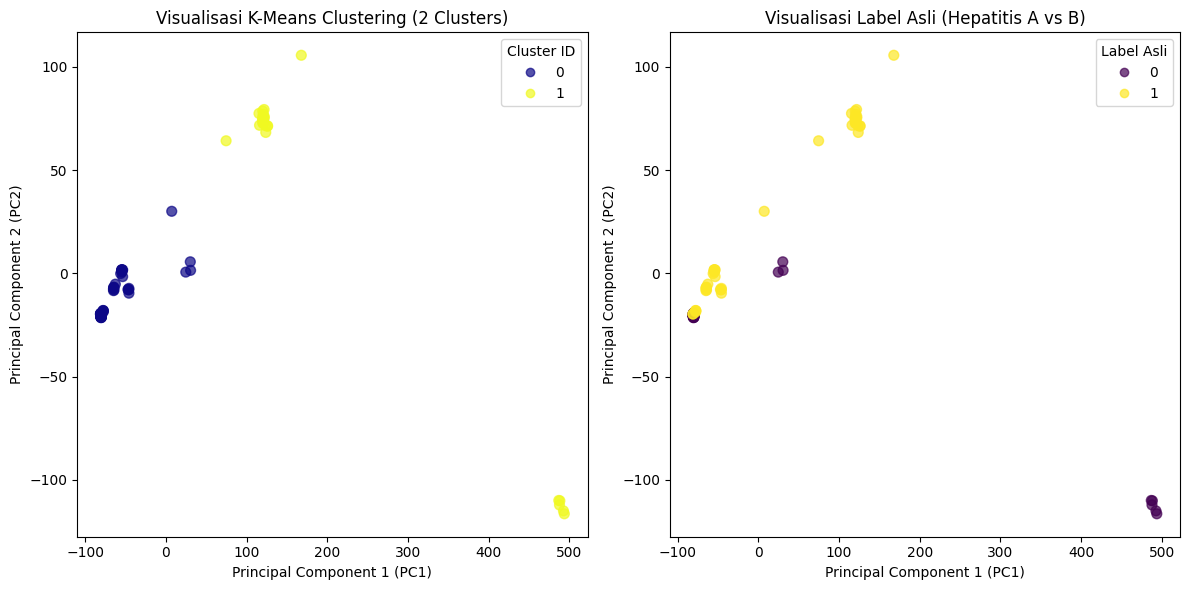

In [ ]:
# Pastikan library yang dibutuhkan untuk Filogenetik sudah terimpor:
# from scipy.spatial.distance import pdist, squareform
# from scipy.cluster.hierarchy import linkage, dendrogram
# import matplotlib.pyplot as plt

# ==============================================================================
# K-MEANS CLUSTERING & VISUALISASI PCA
# ==============================================================================

K_CLUSTERS = 2
kmeans_model = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_kmer)
data_df['cluster'] = cluster_labels

print(f"\n✅ K-Means Clustering selesai (K={K_CLUSTERS}).")
print("Perbandingan Label Asli vs. Hasil Cluster:")
print(pd.crosstab(data_df['label'], data_df['cluster']))

# Visualisasi PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_kmer.toarray())
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['cluster'] = data_df['cluster']
pca_df['label'] = data_df['label']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1 (Clustering K-Means)
scatter1 = ax1.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='plasma', s=50, alpha=0.7)
ax1.set_title(f'Visualisasi K-Means Clustering ({K_CLUSTERS} Clusters)')
ax1.set_xlabel('Principal Component 1 (PC1)')
ax1.set_ylabel('Principal Component 2 (PC2)')
ax1.legend(*scatter1.legend_elements(), title="Cluster ID")

# Subplot 2 (Label Asli)
scatter2 = ax2.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['label'].astype('category').cat.codes, cmap='viridis', s=50, alpha=0.7)
ax2.set_title('Visualisasi Label Asli (Hepatitis A vs B)')
ax2.set_xlabel('Principal Component 1 (PC1)')
ax2.set_ylabel('Principal Component 2 (PC2)')
ax2.legend(*scatter2.legend_elements(), title="Label Asli")

plt.tight_layout()
plt.show()

HASIL POHON FILOGENETIK (DENDROGRAM)


--- Menghitung Matriks Jarak untuk Pohon Filogenetik ---


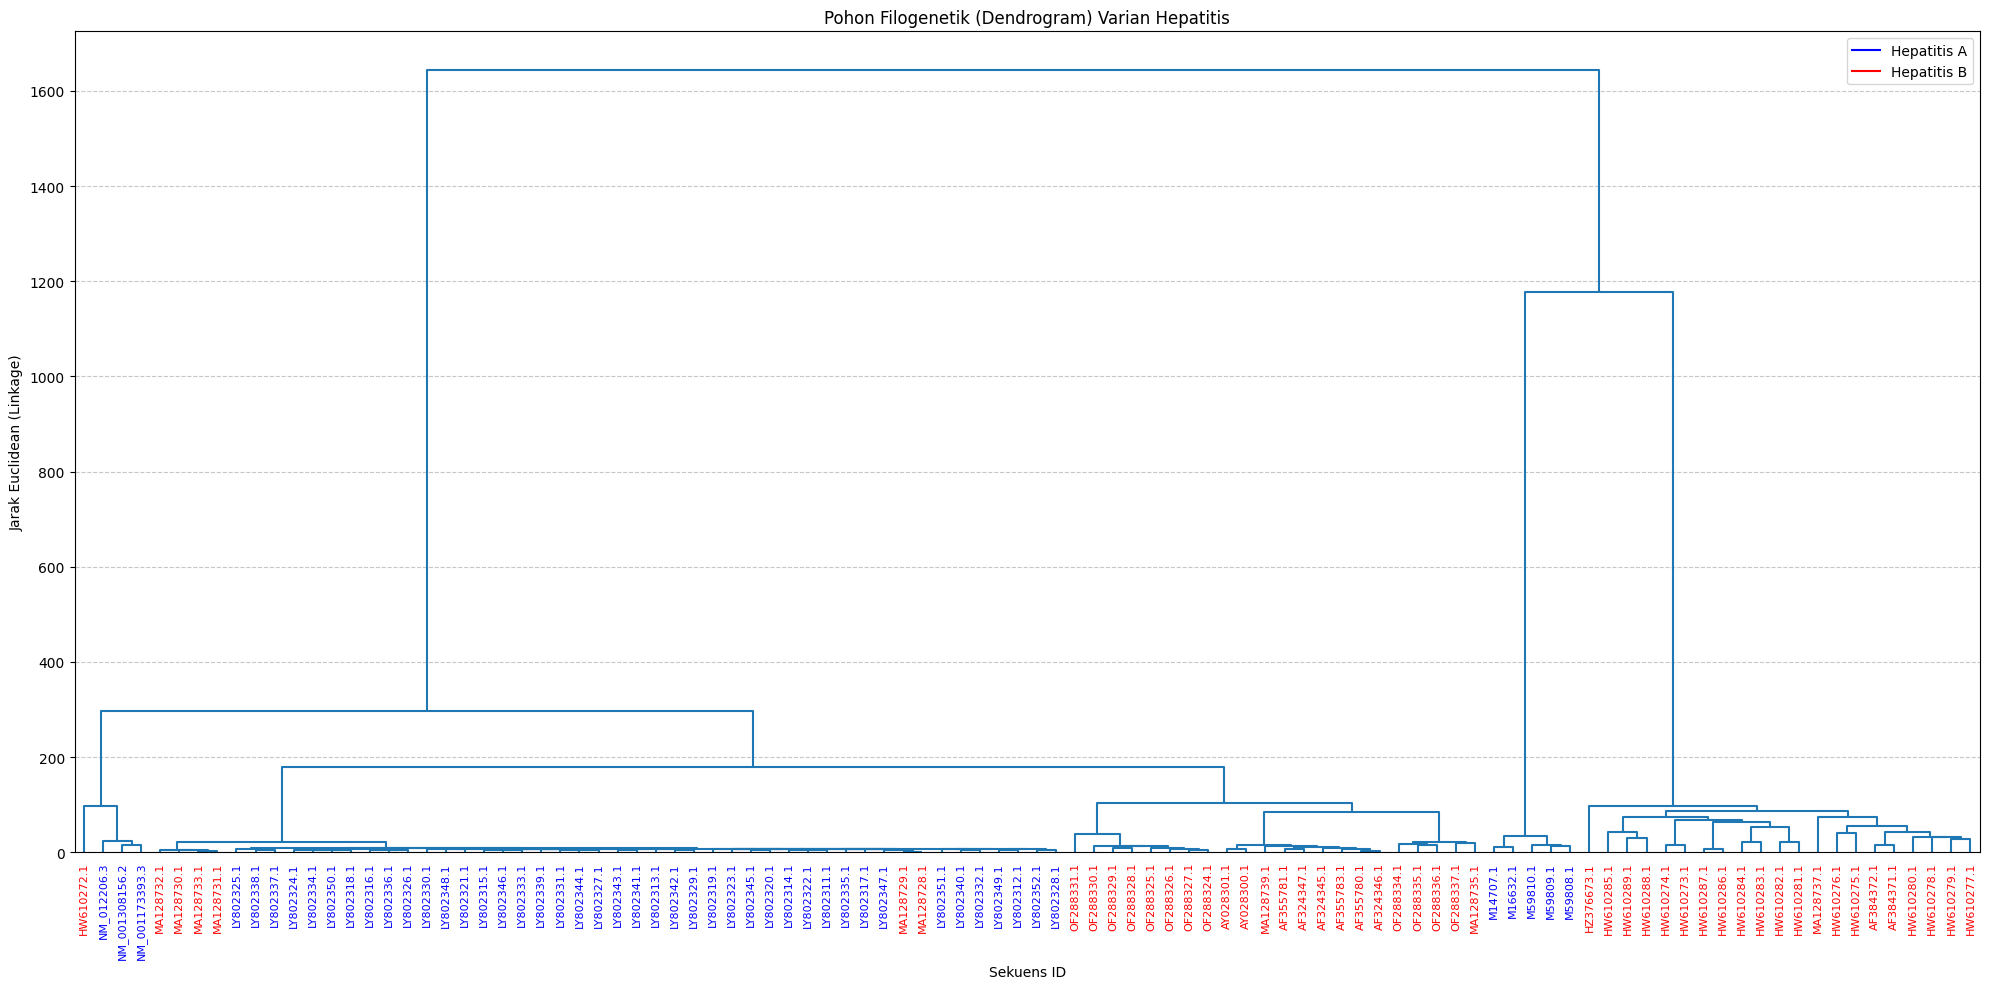

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

print("\n--- Menghitung Matriks Jarak untuk Pohon Filogenetik ---")

# 1. Hitung Matriks Jarak (Euclidean Distance pada Matriks K-mer)
# Menggunakan pdist pada array padat (dense array)
distance_matrix = pdist(X_kmer.toarray(), metric='euclidean')

# 2. Lakukan Linkage (Hierarchical Clustering)
linkage_matrix = linkage(distance_matrix, method='ward')

# 3. Plot Dendrogram
plt.figure(figsize=(20, 10))
plt.title('Pohon Filogenetik (Dendrogram) Varian Hepatitis')
plt.xlabel('Sekuens ID')
plt.ylabel('Jarak Euclidean (Linkage)')

# Tentukan warna label
color_map = {'HepatitisA': 'blue', 'HepatitisB': 'red'}

# Buat dictionary untuk memetakan ID sekuens ke label asli
id_to_label = data_df.set_index('id')['label'].to_dict()

# Plot Dendrogram
dendro = dendrogram(
    linkage_matrix,
    labels=data_df['id'].tolist(),
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_leaf_counts=False,
    color_threshold=0.0,
)

# Mewarnai label daun dendrogram sesuai jenis Hepatitis
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    seq_id = lbl.get_text()
    # Gunakan mapping id_to_label untuk mendapatkan label yang benar
    if seq_id in id_to_label:
        label = id_to_label[seq_id]
        lbl.set_color(color_map.get(label, 'black')) # Default to black if label not in color_map

# Tambahkan legenda
plt.plot([], [], color='blue', label='Hepatitis A')
plt.plot([], [], color='red', label='Hepatitis B')
plt.legend(loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

PEMODELAN KLASIK VS DEEP LEARNING

PEMODELAN KLASIK (SVM)

In [ ]:
# --- A. PEMODELAN KLASIK (SVM) ---
svm_model = SVC(kernel='linear', random_state=42)
print("\nMemulai pelatihan SVM...")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"\n✅ Akurasi SVM: {accuracy_svm*100:.2f}%")
print("Laporan Klasifikasi SVM:\n", classification_report(y_test, y_pred_svm))


Memulai pelatihan SVM...

✅ Akurasi SVM: 95.00%
Laporan Klasifikasi SVM:
               precision    recall  f1-score   support

  HepatitisA       1.00      0.90      0.95        10
  HepatitisB       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



PEMODELAN KLASIK (RANDOM FOREST)

In [ ]:
# --- B. PEMODELAN KLASIK (RANDOM FOREST) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
print("\nMemulai pelatihan Random Forest...")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"\n✅ Akurasi Random Forest: {accuracy_rf*100:.2f}%")
print("Laporan Klasifikasi Random Forest:\n", classification_report(y_test, y_pred_rf))


Memulai pelatihan Random Forest...

✅ Akurasi Random Forest: 100.00%
Laporan Klasifikasi Random Forest:
               precision    recall  f1-score   support

  HepatitisA       1.00      1.00      1.00        10
  HepatitisB       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Perbandingan SVM dan Random Forest

In [ ]:
# ==============================================================================
# 🎯 LANGKAH 5.1: RINGKASAN AKURASI KLASIK
# ==============================================================================

print("\n--- RINGKASAN AKURASI KLASIFIKASI KLASIK ---")
print(f"1. Support Vector Machine (SVM) Akurasi: {accuracy_svm*100:.2f}%")
print(f"2. Random Forest (RF) Akurasi: {accuracy_rf*100:.2f}%")

if accuracy_svm > accuracy_rf:
    print("\n💡 KESIMPULAN AWAL: SVM sedikit lebih unggul. Hal ini menunjukkan batas pemisah linier cukup efektif di ruang fitur K-mer.")
elif accuracy_rf > accuracy_svm:
    print("\n💡 KESIMPULAN AWAL: Random Forest sedikit lebih unggul. Ini menunjukkan batas pemisah yang non-linier mungkin lebih baik untuk data Anda.")
else:
    print("\n💡 KESIMPULAN AWAL: Kinerja kedua model hampir identik, membuktikan K-mer adalah fitur pemisah yang sangat kuat.")


--- RINGKASAN AKURASI KLASIFIKASI KLASIK ---
1. Support Vector Machine (SVM) Akurasi: 95.00%
2. Random Forest (RF) Akurasi: 100.00%

💡 KESIMPULAN AWAL: Random Forest sedikit lebih unggul. Ini menunjukkan batas pemisah yang non-linier mungkin lebih baik untuk data Anda.


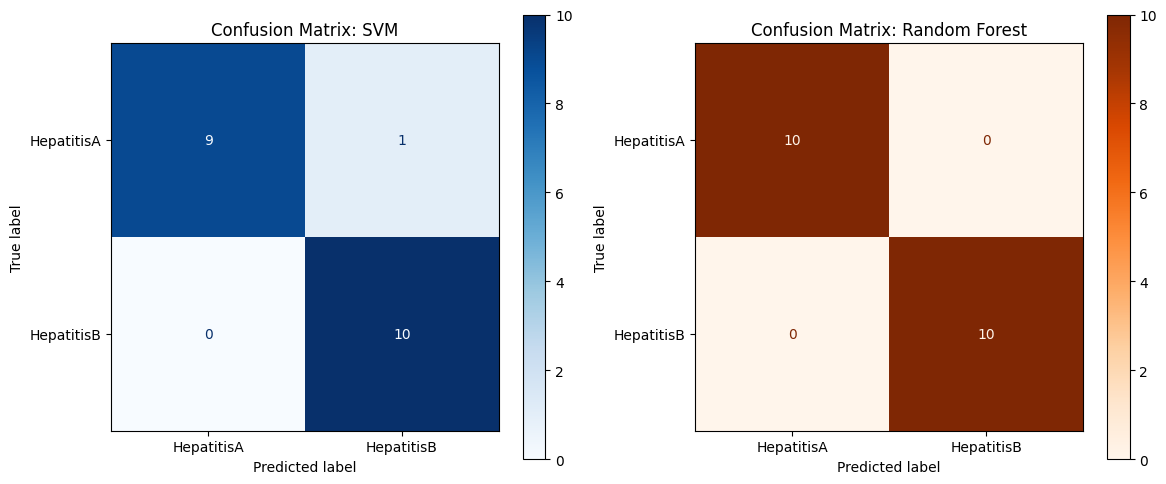

In [ ]:
# ==============================================================================
# 🎯 VISUALISASI 5.2: MATRIKS KONFUSI (SVM vs. RANDOM FOREST)
# ==============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Label kelas unik
labels = sorted(y_test.unique())

plt.figure(figsize=(12, 5))

# --- Matriks Konfusi SVM ---
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
plt.subplot(1, 2, 1)
disp_svm.plot(ax=plt.gca(), cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix: SVM')

# --- Matriks Konfusi Random Forest ---
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)
plt.subplot(1, 2, 2)
disp_rf.plot(ax=plt.gca(), cmap=plt.cm.Oranges, values_format='d')
plt.title('Confusion Matrix: Random Forest')

plt.tight_layout()
plt.show()

PEMODELAN DEEP LEARNING (CNN 1D - VERSI OPTIMASI)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



✅ Model CNN 1D siap untuk dilatih.

✅ Akurasi Deep Learning (CNN 1D): 50.00%

--- Analisis Confusion Matrix ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step

Matriks Konfusi:
[[ 0 10]
 [ 0 10]]

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Kelas 0       0.00      0.00      0.00        10
     Kelas 1       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



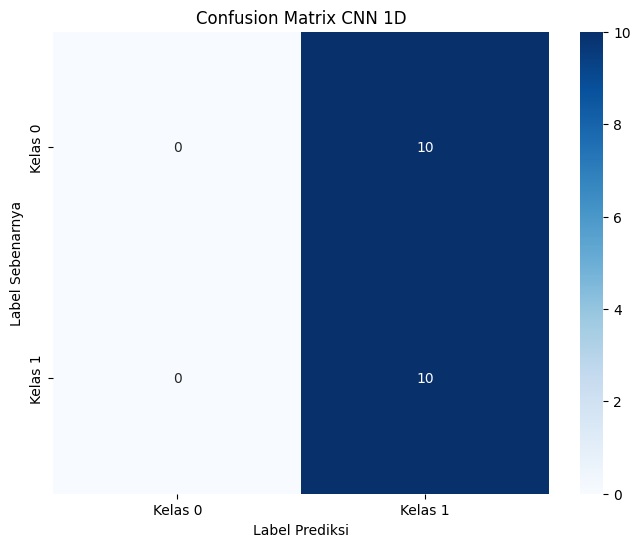

In [ ]:
import seaborn as sns
# (Kode Model CNN yang asli)
VOCAB_SIZE = len(tokenizer.word_index) + 1 # Ganti dengan definisi variabel Anda
# Asumsi: tokenizer, MAX_LENGTH, NUM_CLASSES, X_train_dl, y_train_dl, X_test_dl, y_test_dl sudah tersedia
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=10, input_length=MAX_LENGTH),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("\n✅ Model CNN 1D siap untuk dilatih.")

# Pelatihan Model CNN
EPOCHS = 10
# Asumsi: Anda sudah melatih model di sini:
# history = model_cnn.fit(...)

# Evaluasi
loss, accuracy_dl = model_cnn.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"\n✅ Akurasi Deep Learning (CNN 1D): {accuracy_dl*100:.2f}%")


# -----------------------------------------------------------------
# --- PENAMBAHAN UNTUK CONFUSION MATRIX DAN CLASSIFICATION REPORT ---
# -----------------------------------------------------------------

print("\n--- Analisis Confusion Matrix ---")

# 1. Melakukan Prediksi
# Gunakan model untuk memprediksi probabilitas kelas pada data uji
y_pred_probs = model_cnn.predict(X_test_dl)

# 2. Mengkonversi Probabilitas ke Label Kelas
# Ambil indeks dengan probabilitas tertinggi (kelas yang diprediksi)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 3. Mengkonversi Label Uji One-Hot ke Label Kelas
# Ambil indeks dengan nilai 1 (kelas sebenarnya) dari label uji one-hot
y_true_classes = np.argmax(y_test_dl, axis=1)

# 4. Menghitung Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nMatriks Konfusi:")
print(cm)

# 5. Menampilkan Classification Report (Precision, Recall, F1-Score)
print("\nLaporan Klasifikasi:")
# Anda perlu mendefinisikan nama kelas (misalnya, berdasarkan tokenizer/dataset Anda)
# Ganti ['Kelas_0', 'Kelas_1', 'Kelas_2'] dengan nama kelas Anda yang sebenarnya
class_names = [f'Kelas {i}' for i in range(NUM_CLASSES)]
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0))

# 6. Visualisasi Confusion Matrix (Opsional, tapi sangat dianjurkan)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix CNN 1D')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.show()

# -----------------------------------------------------------------